In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
df = pd.read_excel('Nile.xlsx')
df = df.rename(columns={'Unnamed: 0':'Year'})
df

,Year,Nile
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160
...,...,...
95,1966,746
96,1967,919
97,1968,718
98,1969,714


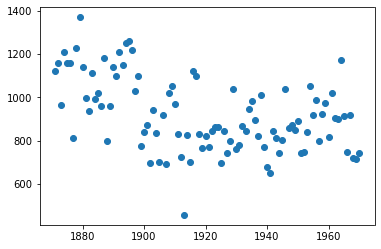

In [24]:
plt.scatter(df['Year'], df['Nile'])

In [25]:
def kalman_filter(z, F, H, Q, R, x, P):
    # Prediction step
    x = np.dot(F, x)
    P = np.dot(np.dot(F, P), F.T) + Q
    
    # Update step
    y = z - np.dot(H, x)
    S = np.dot(np.dot(H, P), H.T) + R
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
    x = x + np.dot(K, y)
    P = np.dot((np.eye(len(x)) - np.dot(K, H)), P)
    
    return x, P 

In [27]:
def local_level_kalman_filter(data, level_var, obs_var, level_sd, obs_sd):
    n = len(data)

    # Set up matrices for the local level model
    F = np.array([[1, 1], [0, 1]])  # State transition matrix
    Q = np.array([[level_var, 0], [0, level_sd**2]])  # Process noise covariance
    H = np.array([[1, 0]])  # Observation matrix
    R = obs_var  # Observation noise covariance

    # Initialize state estimate and error covariance
    x = np.array([data[0], 0])  # Initial state estimate
    P = np.array([[obs_sd**2, 0], [0, level_sd**2]])  # Initial error covariance

    # Run the Kalman filter for each observation in the data
    for i in range(1, n):
        z = data[i]  # Get the current observation

        # Perform the Kalman filter predict and update steps
        x = np.dot(F, x)
        P = np.dot(np.dot(F, P), F.T) + Q
        y = z - np.dot(H, x)
        S = np.dot(np.dot(H, P), H.T) + R
        K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
        x = x + np.dot(K, y)
        I = np.eye(P.shape[0])
        P = np.dot(I - np.dot(K, H), P)

    return x, P

In [70]:


def KF_LL(a_ini, P_ini, sig_e, sig_eta):
    a =  np.zeros(len(df))
    a[0] = a_ini

    v = np.zeros(len(df))
    v[0] = data_nile[0] - a[0]

    P = np.zeros(len(df))
    P[0] = P_ini

    F = np.zeros(len(df))
    K = np.zeros(len(df))

    for t in range(0, len(df)-1):
        v[t] = data_nile[t] - a[t]
        F[t] = P[t] + sig_e
        K[t] = P[t] / F[t]

        a[t+1] = a[t] + K[t] * v[t]
        P[t+1] = K[t] * sig_e + sig_eta

    return (v, P, F)

data_nile = df['Nile']
years = df['Year']

a_ini = 0
P_ini = 10**7
sig_e = 15099
sig_eta = 1469.1

v, P, F = KF_LL(a_ini, P_ini, sig_e, sig_eta)

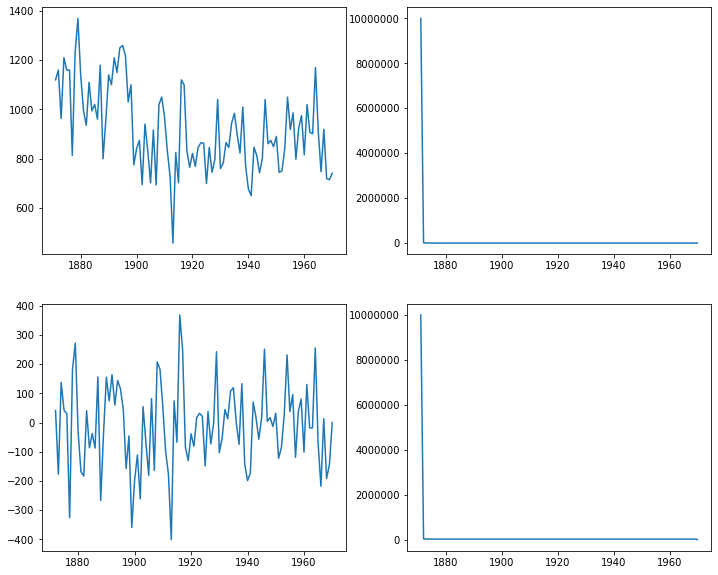

In [71]:
# fig_1_vals = pd.DataFrame([[v, P]])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,10))
ax1.plot(years, data_nile)
ax2.plot(years, P)
ax2.ticklabel_format(style='plain')
ax3.plot(years[1:], v[1:])
ax4.plot(years, F)
ax4.ticklabel_format(style='plain')